# Regularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem statement:** You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head.

![Football field](field_kiank.png)

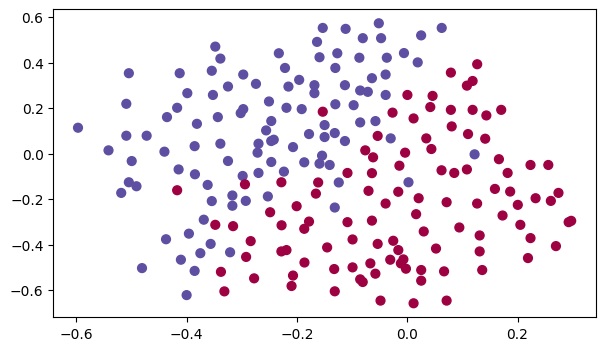

In [2]:
# dataset
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot is a position on the footbal field where a football player has hit the ball with his head after the French goal keeper has shot the ball from the left side of the footbal field. A blue dot mens the French player managed to hit the ball with his head. A red dot means the other team's players did it.

Looks like a diagonal line in the footbal field would be a fairly good classifier for this dataset.

### Non-regularized model

In [3]:
# model
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Training the model without any type of regularization:

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724216
Cost after iteration 20000: 0.13851642423254343


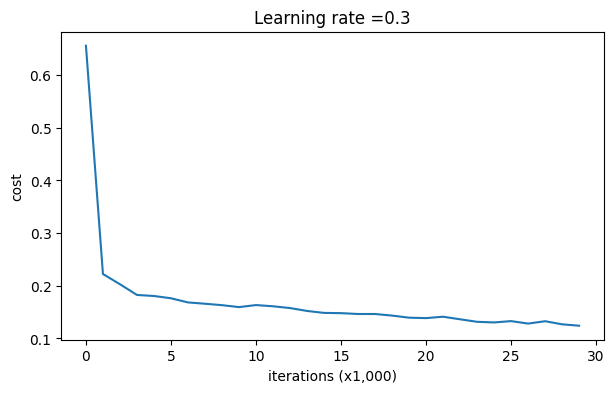

Train set:
Accuracy: 0.9478672985781991
Test set:
Accuracy: 0.915


In [4]:
parameters = model(train_X, train_Y)
print ('Train set:')
predictions_train = predict(train_X, train_Y, parameters)
print ('Test set:')
predictions_test = predict(test_X, test_Y, parameters)

The accuracy in the train set is ~3% larger than the accuracy in the test set.

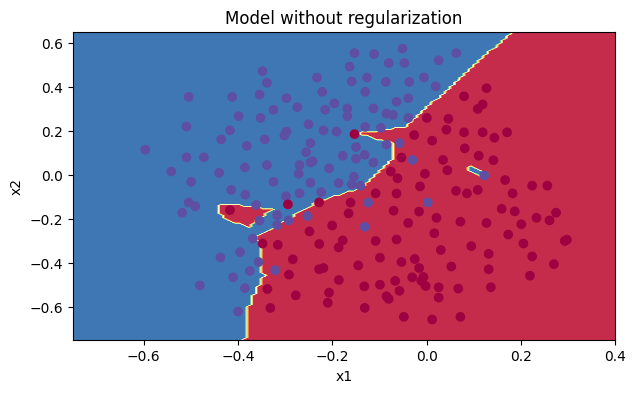

In [5]:
plt.title('Model without regularization')
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

We see some signs of overfitting in the decision boundary.

### L2 Regularization

Create a function that computes the cost with L2 regularization:

In [6]:
def compute_cost_with_regularization(A3, Y, parameters, lambd): # lambda is a reserved word
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = (lambd/(2*m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [7]:
# test the function
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


Change the backpropagation function:

In [8]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    # layer 3
    dZ3 = A3 - Y
    dW3 = ((1./m) * np.dot(dZ3,A2.T)) + ((lambd/m) * W3)
    db3 = (1./m) * np.sum(dZ3, axis=1, keepdims = True)
    
    # layer 2
    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = ((1./m) * np.dot(dZ2,A1.T)) + ((lambd/m) * W2)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims = True)

    # layer 1
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = ((1./m) * np.dot(dZ1,X.T)) + ((lambd/m) * W1)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {
        'dZ3': dZ3,
        'dW3': dW3,
        'db3': db3,
        'dA2': dA2,
        'dZ2': dZ2,
        'dW2': dW2,
        'db2': db2,
        'dA1': dA1,
        'dZ1': dZ1,
        'dW1': dW1,
        'db1': db1
    }

    return gradients

In [9]:
# testing the function
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Training the model with L2 regularization:

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


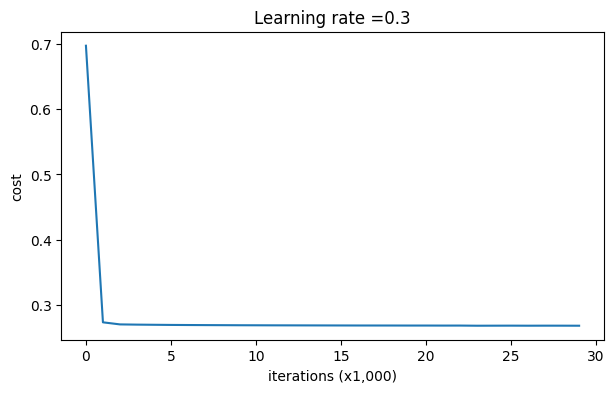

Train set:
Accuracy: 0.9383886255924171
Test set:
Accuracy: 0.93


In [10]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ('Train set:')
predictions_train = predict(train_X, train_Y, parameters)
print ('Test set:')
predictions_test = predict(test_X, test_Y, parameters)

With L2 regularization the accuracy of both train and test sets are similar. Train accuracy decreased by ~1% but the test accuracy improved.

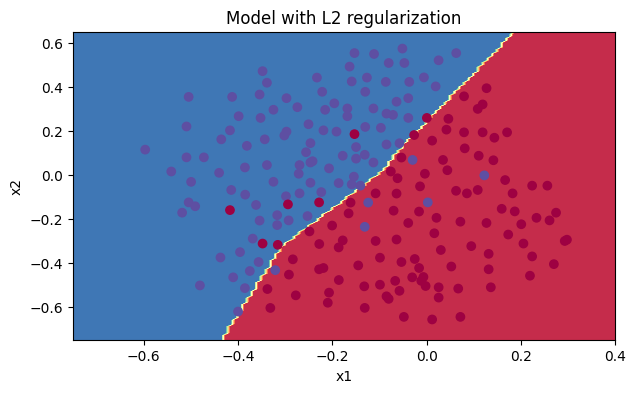

In [11]:
plt.title('Model with L2 regularization')
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Decision boundaries looks better, smoother.

**To remember:**
- L2 regularization changes the cost computation.
- It also changes the backpropagation (extra terms in the gradients).

### Dropout

Change the forward propagation function to apply dropout to first and second layers:

In [12]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # 1st layer
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = (np.random.rand(A1.shape[0], A1.shape[1]) < keep_prob).astype(int)
    A1 = np.multiply(A1, D1)
    A1 = A1/keep_prob

    # 2nd layer
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = (np.random.rand(A2.shape[0], A2.shape[1]) < keep_prob).astype(int)
    A2 = np.multiply(A2, D2)
    A2 = A2/keep_prob

    # 3rd layer
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [13]:
# testing the function
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


Now change the backward propagation function:

In [14]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    # 3rd layer
    dZ3 = A3 - Y
    dW3 = (1./m) * np.dot(dZ3, A2.T)
    db3 = (1./m) * np.sum(dZ3, axis=1, keepdims = True)

    # 2nd layer
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2,D2)
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m) * np.dot(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims = True)
    
    # 1st layer
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1,D1)
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {
        'dZ3': dZ3,
        'dW3': dW3,
        'db3': db3,
        'dA2': dA2,
        'dZ2': dZ2,
        'dW2': dW2,
        'db2': db2,
        'dA1': dA1,
        'dZ1': dZ1,
        'dW1': dW1,
        'db1': db1
    }
    
    return gradients

In [15]:
# testing the function
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Training the model with dropout:

Cost after iteration 0: 0.6543912405149825


/home/jessica/Documents/Courses/data_science_studies/deep_learning_specialization/2_improving_neural_networks/1_practical_aspects_of_deep_learning/reg_utils.py:236: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/jessica/Documents/Courses/data_science_studies/deep_learning_specialization/2_improving_neural_networks/1_practical_aspects_of_deep_learning/reg_utils.py:236: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


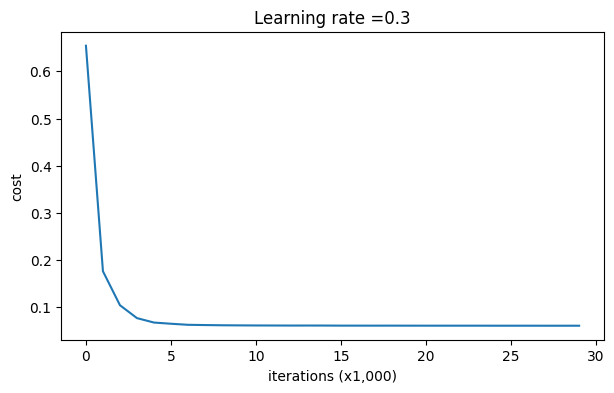

Train set:
Accuracy: 0.9289099526066351
Test set:
Accuracy: 0.95


In [16]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3)
print ('Train set:')
predictions_train = predict(train_X, train_Y, parameters)
print ('Test set:')
predictions_test = predict(test_X, test_Y, parameters)

With dropout the test accuracy is even larger than with L2 regularization. Train accuracy dropped.

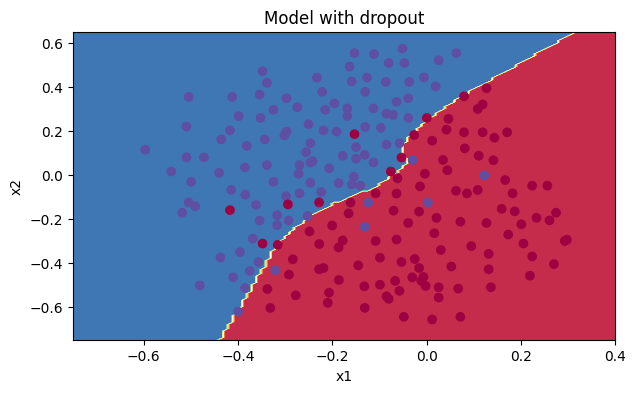

In [17]:
plt.title('Model with dropout')
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Decision boundary is also smooth.

**To remember:**
- Dropout is only used during training (removing nodes and dividing matrix A by `keep_dims`).
- Dropout needs to be applied during forward and backward pass (the gradient value is zero for the node deactivated for a given observation).